# Neural style transfer
As part of Fast AI's challenge for students, I will be implementing neural style transfer. Given that I am training primarily on my M1 MacBook Pro's GPU (read: slow training), I may set some aspects to be easier to train (e.g. less epochs, less classes etc).

Let's have a go at it and see what happens.

In [1]:
import shutil,os,torch,random,datasets,math
import fastcore.all as fc, numpy as np, matplotlib as mpl, matplotlib.pyplot as plt
import torchvision.transforms as T
import torchvision.transforms.functional as TF,torch.nn.functional as F

from torch.utils.data import DataLoader,default_collate
from pathlib import Path
from torch.nn import init
from fastcore.foundation import L
from torch import nn,tensor
from operator import itemgetter
from torcheval.metrics import MulticlassAccuracy
from functools import partial
from torch.optim import lr_scheduler
from torch import optim
from torchvision import transforms
from torchvision.io import read_image,ImageReadMode
from glob import glob
from sklearn.model_selection import train_test_split
from IPython.display import display

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *
from miniai.accel import *
from miniai.training import *

In [2]:
from PIL import Image

In [3]:
from fastprogress import progress_bar

In [4]:
torch.set_printoptions(precision=5, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['figure.dpi'] = 70

set_seed(42)
if fc.defaults.cpus>8: fc.defaults.cpus=8

## Data processing (style images)

In [5]:
path_data = Path('data')
path_data.mkdir(exist_ok=True)
path = path_data/'tiny-best-artwork'

We need to split our data into train test folders.

In [6]:
data_prepped = True

In [7]:
if not data_prepped:
    for artist_folder in path.iterdir():
        if artist_folder.is_dir():
            files = list(glob(str(artist_folder/'*.jpg')))
            train_files, test_files = train_test_split(files, test_size=0.2)

            # Create `train` and `test` folders
            train_folder = artist_folder / 'train'
            test_folder = artist_folder / 'test'
            os.makedirs(train_folder, exist_ok=True)
            os.makedirs(test_folder, exist_ok=True)

            # Move files to `train` folder
            for train_file in train_files:
                shutil.move(train_file, train_folder / os.path.basename(train_file))

            # Move files to `test` folder
            for test_file in test_files:
                shutil.move(test_file, test_folder / os.path.basename(test_file))


In [8]:
bs = 128

### Prep `train_ds` and `val_ds`

In [9]:
class TinyDS:
    def __init__(self, path, train_or_test):
        self.path = Path(path)
        self.files = glob(str(self.path/f"*/{train_or_test}/*.jpg"), recursive=True)

    def __len__(self): return len(self.files)

    def __getitem__(self, i):
        return self.files[i], Path(self.files[i]).parent.parent.name

In [10]:
train_ds = TinyDS(path, "train")

In [11]:
len(train_ds)

1104

In [12]:
train_ds[0]

('data/tiny-best-artwork/Albrecht_Du╠êrer/train/Albrecht_Du╠êrer_14.jpg',
 'Albrecht_Du╠êrer')

In [13]:
train_ds[10]

('data/tiny-best-artwork/Albrecht_Du╠êrer/train/Albrecht_Du╠êrer_118.jpg',
 'Albrecht_Du╠êrer')

In [14]:
val_ds = TinyDS(path, "test")

In [15]:
len(val_ds)

279

In [16]:
val_ds[0]

('data/tiny-best-artwork/Albrecht_Du╠êrer/test/Albrecht_Du╠êrer_247.jpg',
 'Albrecht_Du╠êrer')

In [17]:
val_ds[30]

('data/tiny-best-artwork/Albrecht_Du╠êrer/test/Albrecht_Du╠êrer_237.jpg',
 'Albrecht_Du╠êrer')

### Make sure images are read correctly

In [18]:
img = Image.open("data/tiny-best-artwork/Albrecht_Du╠êrer/train/Albrecht_Du╠êrer_14.jpg")


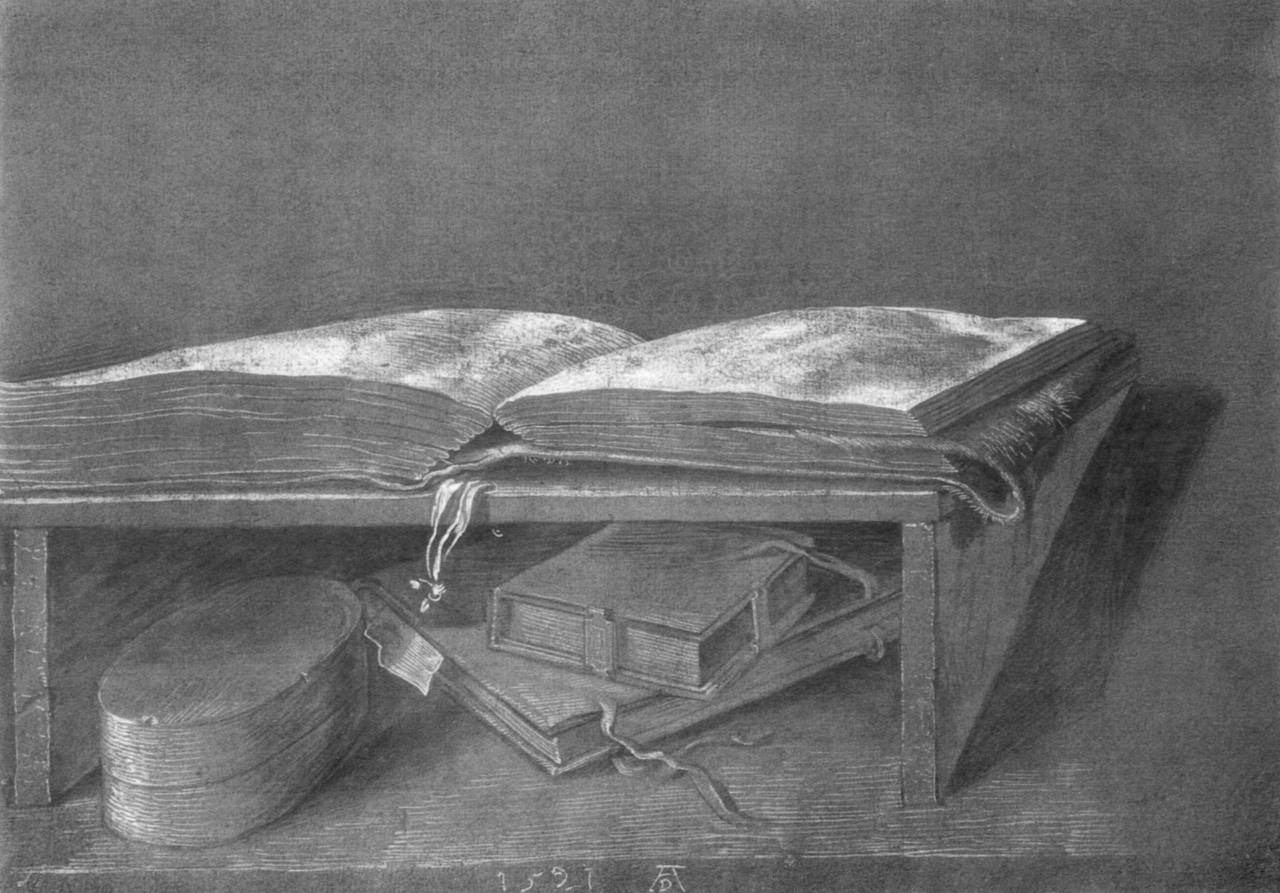

In [19]:
display(img)

In [20]:
transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
])
img_t = transform(img)
img_t.shape

torch.Size([3, 64, 64])

<Axes: >

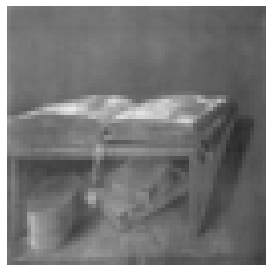

In [21]:
show_image(img_t)

Oddly enough, this looks ok too.

### Normalise/standardise images

In [22]:
train_tensor_list = []

transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
])

for img_path, _ in train_ds:
    img = Image.open(img_path)
    img_t = transform(img)
    if img_t.shape != torch.Size([3, 64, 64]):
        os.remove(img_path)
        print(f"Removed {img_path}")
        continue
    train_tensor_list.append(img_t)

stacked_train_tensors = torch.stack(train_tensor_list, dim=0)
x_mean = torch.mean(stacked_train_tensors, dim=(0,2,3))
x_std = torch.std(stacked_train_tensors, dim=(0,2,3))

x_mean, x_std

(tensor([0.60313, 0.56858, 0.53134]), tensor([0.23981, 0.24546, 0.26040]))

In [23]:
for img_path, _ in val_ds:
    img = Image.open(img_path)
    img_t = transform(img)
    if img_t.shape != torch.Size([3, 64, 64]):
        os.remove(img_path)
        print(f"Removed {img_path}")
        continue

In [24]:
img_t - x_mean[:,None,None]

tensor([[[ 0.08707,  0.06354,  0.06354,  ...,  0.05570,  0.05962,  0.09883],
         [ 0.07138,  0.06354,  0.07530,  ...,  0.08315,  0.08707,  0.08707],
         [ 0.06746,  0.08315,  0.07923,  ...,  0.11060,  0.06354,  0.06746],
         ...,
         [ 0.13805,  0.12628,  0.08707,  ...,  0.19295,  0.18511,  0.18511],
         [ 0.14981,  0.17727,  0.15374,  ...,  0.20079,  0.21256,  0.22825],
         [ 0.16550,  0.19687,  0.19295,  ...,  0.21648,  0.22432,  0.23609]],

        [[-0.02741, -0.08231, -0.08231,  ..., -0.12937, -0.11368, -0.07839],
         [-0.05878, -0.08623, -0.09015,  ..., -0.10584, -0.09015, -0.09407],
         [-0.07054, -0.07447, -0.09015,  ..., -0.07447, -0.12937, -0.12937],
         ...,
         [-0.00388, -0.03525, -0.10976,  ..., -0.01564, -0.01172, -0.00388],
         [ 0.02749,  0.05495, -0.00780,  ...,  0.01181,  0.03534,  0.05887],
         [ 0.05887,  0.09024,  0.06279,  ...,  0.03926,  0.05887,  0.07847]],

        [[-0.18232, -0.23330, -0.24114,  ...

In [25]:
def tfmx(x):
    img = Image.open(x)
    transform = transforms.Compose([
        transforms.Resize((64,64)),
        transforms.ToTensor(),
        # transforms.Normalize(x_mean[:,None,None], x_std[:,None,None]),
    ])
    img_t = transform(img)
    return img_t


In [26]:
str2id = {
    "Albrecht_Du╠êrer": 0,
    "Albrecht_Dürer": 1,
    "Alfred_Sisley": 2,
    "Amedeo_Modigliani": 3,
    "Andrei_Rublev": 4,
    "Andy_Warhol": 5,
}

In [27]:
id2str = {v:k for k,v in str2id.items()}

In [28]:
def tfmy(y): return tensor(str2id[y])

In [29]:
class TfmDS:
    def __init__(self, ds, tfmx=fc.noop, tfmy=fc.noop): self.ds,self.tfmx,self.tfmy = ds,tfmx,tfmy
    def __len__(self): return len(self.ds)
    def __getitem__(self, i):
        x,y = self.ds[i]
        return self.tfmx(x),self.tfmy(y)

In [30]:
tfm_tds = TfmDS(train_ds, tfmx, tfmy)
tfm_vds = TfmDS(val_ds, tfmx, tfmy)

In [31]:
x0, y0 = tfm_tds[0]
x0, y0

(tensor([[[0.52549, 0.48627, 0.47451,  ..., 0.34118, 0.33725, 0.34510],
          [0.49412, 0.45882, 0.44706,  ..., 0.33725, 0.32549, 0.33725],
          [0.48235, 0.44706, 0.43922,  ..., 0.33725, 0.33333, 0.36471],
          ...,
          [0.45098, 0.40784, 0.40784,  ..., 0.28235, 0.25882, 0.26275],
          [0.43922, 0.44706, 0.47059,  ..., 0.25490, 0.23529, 0.25882],
          [0.43137, 0.41176, 0.39216,  ..., 0.27059, 0.25490, 0.26667]],
 
         [[0.52549, 0.48627, 0.47451,  ..., 0.34118, 0.33725, 0.34510],
          [0.49412, 0.45882, 0.44706,  ..., 0.33725, 0.32549, 0.33725],
          [0.48235, 0.44706, 0.43922,  ..., 0.33725, 0.33333, 0.36471],
          ...,
          [0.45098, 0.40784, 0.40784,  ..., 0.28235, 0.25882, 0.26275],
          [0.43922, 0.44706, 0.47059,  ..., 0.25490, 0.23529, 0.25882],
          [0.43137, 0.41176, 0.39216,  ..., 0.27059, 0.25490, 0.26667]],
 
         [[0.52549, 0.48627, 0.47451,  ..., 0.34118, 0.33725, 0.34510],
          [0.49412, 0.45882,

In [32]:
x1, y1 = tfm_tds[1]
x1, y1

(tensor([[[0.99216, 0.98039, 0.97255,  ..., 0.88235, 0.90196, 0.98824],
          [0.98431, 0.81961, 0.83529,  ..., 0.47843, 0.42353, 0.87843],
          [0.98039, 0.86275, 0.86275,  ..., 0.43922, 0.34118, 0.77647],
          ...,
          [0.86667, 0.71373, 0.64706,  ..., 0.57647, 0.77255, 0.96863],
          [0.85490, 0.66275, 0.68627,  ..., 0.55686, 0.74510, 0.96471],
          [0.95686, 0.91765, 0.91765,  ..., 0.76863, 0.82745, 0.97255]],
 
         [[0.99216, 0.98039, 0.97255,  ..., 0.88235, 0.90196, 0.98824],
          [0.98431, 0.81961, 0.83529,  ..., 0.47843, 0.42353, 0.87843],
          [0.98039, 0.86275, 0.86275,  ..., 0.43922, 0.34118, 0.77647],
          ...,
          [0.86667, 0.71373, 0.64706,  ..., 0.57647, 0.77255, 0.96863],
          [0.85490, 0.66275, 0.68627,  ..., 0.55686, 0.74510, 0.96471],
          [0.95686, 0.91765, 0.91765,  ..., 0.76863, 0.82745, 0.97255]],
 
         [[0.99216, 0.98039, 0.97255,  ..., 0.88235, 0.90196, 0.98824],
          [0.98431, 0.81961,

In [33]:
train_ds[0]

('data/tiny-best-artwork/Albrecht_Du╠êrer/train/Albrecht_Du╠êrer_14.jpg',
 'Albrecht_Du╠êrer')

In [34]:
train_ds[1]

('data/tiny-best-artwork/Albrecht_Du╠êrer/train/Albrecht_Du╠êrer_253.jpg',
 'Albrecht_Du╠êrer')

<Axes: >

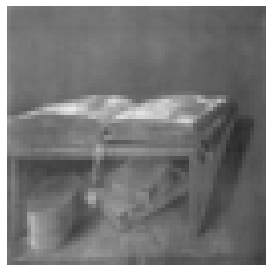

In [35]:
show_image(x0)

In [36]:
torch.max(x0)

tensor(0.90980)

In [37]:
torch.min(x0)

tensor(0.16471)

Because standardisation skews the min/max pixel values to be (imo) not within the same range (-2 to 1), I've decided to put aside standardisation first and try it out later if necessary.

### DataLoaders

In [38]:
train_dl = DataLoader(tfm_tds, batch_size=bs, shuffle=True, num_workers=0)
valid_dl = DataLoader(tfm_vds, batch_size=bs, shuffle=False, num_workers=0)

In [39]:
xb, yb = b = next(iter(train_dl))

In [40]:
len(xb)

128

In [41]:
titles = [id2str[int(o)] for o in yb]
', '.join(titles[:16])

'Andy_Warhol, Albrecht_Du╠êrer, Andrei_Rublev, Amedeo_Modigliani, Andrei_Rublev, Albrecht_Dürer, Amedeo_Modigliani, Albrecht_Du╠êrer, Alfred_Sisley, Amedeo_Modigliani, Alfred_Sisley, Alfred_Sisley, Albrecht_Dürer, Alfred_Sisley, Andrei_Rublev, Albrecht_Du╠êrer'

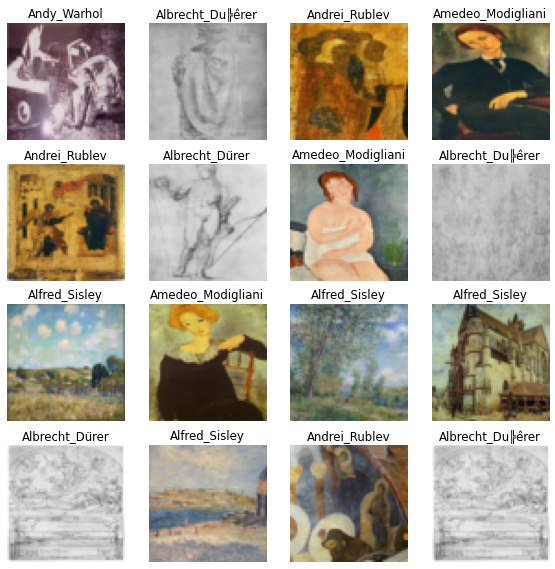

In [42]:
show_images(xb[:16], titles=titles[:16], imsize=2.5)

In [43]:
dls = DataLoaders(*get_dls(tfm_tds, tfm_vds, bs=bs, num_workers=1))

## Basic Model

In [44]:
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
iw = partial(init_weights, leaky=0.1)

In [66]:
nfs = (8, 16, 32, 64, 128)

In [67]:
def get_dropmodel(act=act_gr, nfs=nfs, norm=nn.BatchNorm2d, drop=0.1):
    layers = [nn.Conv2d(3, nfs[0], 5, padding=2)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2)
               for i in range(len(nfs)-1)]
    layers += [nn.AdaptiveAvgPool2d(1), nn.Flatten(), nn.Dropout(drop)]
    #layers += [nn.Linear(nfs[-1], 6, bias=False), nn.BatchNorm1d(6)]
    layers += [nn.Linear(nfs[-1], 64, bias=True), 
               nn.Linear(64, 16, bias=True),
               nn.Linear(16, 6, bias=False),
               nn.BatchNorm1d(6)]
    return nn.Sequential(*layers).apply(iw).to(def_device)

/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


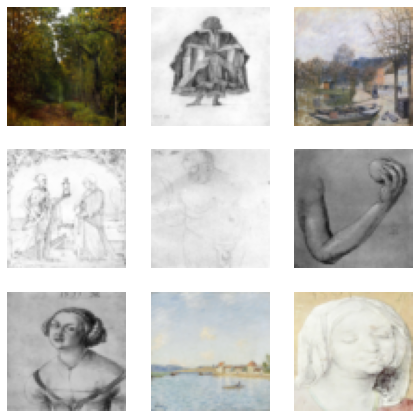

In [68]:
learn = TrainLearner(get_dropmodel(), dls, F.cross_entropy, cbs=[SingleBatchCB(), DeviceCB()])
learn.fit(1)
xb,yb = learn.batch
show_images(xb.cpu()[:9], imsize=2.5)

In [69]:
learn.summary()

/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


Tot params: 316332; MFLOPS: 17.1


|Module|Input|Output|Num params|MFLOPS|
|--|--|--|--|--|
|Conv2d|(128, 3, 64, 64)|(128, 8, 64, 64)|608|2.5|
|ResBlock|(128, 8, 64, 64)|(128, 16, 32, 32)|3696|3.7|
|ResBlock|(128, 16, 32, 32)|(128, 32, 16, 16)|14560|3.7|
|ResBlock|(128, 32, 16, 16)|(128, 64, 8, 8)|57792|3.7|
|ResBlock|(128, 64, 8, 8)|(128, 128, 4, 4)|230272|3.7|
|AdaptiveAvgPool2d|(128, 128, 4, 4)|(128, 128, 1, 1)|0|0.0|
|Flatten|(128, 128, 1, 1)|(128, 128)|0|0.0|
|Dropout|(128, 128)|(128, 128)|0|0.0|
|Linear|(128, 128)|(128, 64)|8256|0.0|
|Linear|(128, 64)|(128, 16)|1040|0.0|
|Linear|(128, 16)|(128, 6)|96|0.0|
|BatchNorm1d|(128, 6)|(128, 6)|12|0.0|


In [70]:
opt_func = partial(optim.AdamW, eps=1e-5)

In [71]:
lr_cbs = [DeviceCB(), ProgressCB()]

/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)
/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)
/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started 

KeyboardInterrupt: 

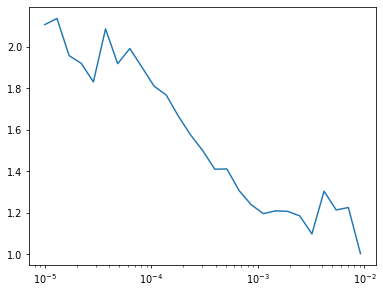

In [72]:
learn = TrainLearner(get_dropmodel(), dls, F.cross_entropy, cbs=lr_cbs, opt_func=opt_func)
learn.lr_find()

In [73]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [DeviceCB(), metrics, ProgressCB(plot=True)]

In [74]:
epochs=25
lr=1e-3
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
learn = TrainLearner(get_dropmodel(), dls, F.cross_entropy, lr=lr, cbs=cbs, opt_func=opt_func)

/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)
/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


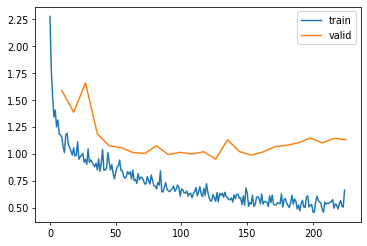

/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)
/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)
/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started 

In [75]:
learn.fit(epochs)

We see that validation loss stops dropping around epoch 13. Let's try a deeper model.

## Deeper model

In [76]:
def res_blocks(n_bk, ni, nf, stride=1, ks=3, act=act_gr, norm=None):
    return nn.Sequential(*[
        ResBlock(ni if i==0 else nf, nf, stride=stride if i==n_bk-1 else 1, ks=ks, act=act, norm=norm)
        for i in range(n_bk)])

In [77]:
nbks = (3,2,2,1,1)

In [97]:
def get_dropmodel(act=act_gr, nfs=nfs, nbks=nbks, norm=nn.BatchNorm2d, drop=0.2):
    layers = [ResBlock(3, nfs[0], ks=5, stride=1, act=act, norm=norm)]
    layers += [res_blocks(nbks[i], nfs[i], nfs[i+1], act=act, norm=norm, stride=2)
               for i in range(len(nfs)-1)]
    layers += [nn.AdaptiveAvgPool2d(1), nn.Flatten(), nn.Dropout(drop)]
    #layers += [nn.Linear(nfs[-1], 200, bias=False), nn.BatchNorm1d(200)]
    layers += [nn.Linear(nfs[-1], 64, bias=True),
               nn.Linear(64, 32, bias=True),
               nn.Linear(32, 6, bias=False),
               nn.BatchNorm1d(6)]
    return nn.Sequential(*layers).apply(iw).to(def_device)

In [88]:
learn = TrainLearner(get_dropmodel(), dls, F.cross_entropy, cbs=[SingleBatchCB(), DeviceCB()])

In [89]:
learn.summary()

/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


Tot params: 421284; MFLOPS: 42.7


|Module|Input|Output|Num params|MFLOPS|
|--|--|--|--|--|
|ResBlock|(128, 3, 64, 64)|(128, 8, 64, 64)|2280|9.1|
|Sequential|(128, 8, 64, 64)|(128, 16, 32, 32)|13104|13.1|
|Sequential|(128, 16, 32, 32)|(128, 32, 16, 16)|33184|8.4|
|Sequential|(128, 32, 16, 16)|(128, 64, 8, 8)|131904|8.4|
|Sequential|(128, 64, 8, 8)|(128, 128, 4, 4)|230272|3.7|
|AdaptiveAvgPool2d|(128, 128, 4, 4)|(128, 128, 1, 1)|0|0.0|
|Flatten|(128, 128, 1, 1)|(128, 128)|0|0.0|
|Dropout|(128, 128)|(128, 128)|0|0.0|
|Linear|(128, 128)|(128, 64)|8256|0.0|
|Linear|(128, 64)|(128, 32)|2080|0.0|
|Linear|(128, 32)|(128, 6)|192|0.0|
|BatchNorm1d|(128, 6)|(128, 6)|12|0.0|


In [90]:
opt_func = partial(optim.AdamW, eps=1e-5)

/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)
/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)
/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started 

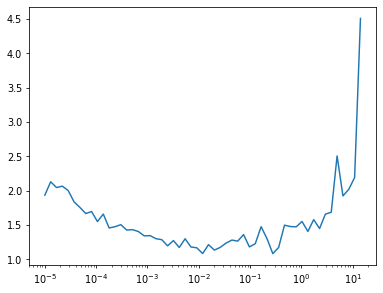

In [91]:
learn = TrainLearner(get_dropmodel(), dls, F.cross_entropy, cbs=lr_cbs, opt_func=opt_func)
learn.lr_find()

In [98]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [DeviceCB(), metrics, ProgressCB(plot=True)]

epochs = 20
lr = 5e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
learn = TrainLearner(get_dropmodel(), dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=opt_func)

/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)
/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


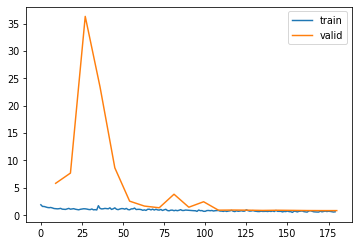

/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)
/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)
/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started 

In [99]:
learn.fit(epochs)

We see a slight improvement in evaluation score. Let's try to set a lower learning rate and see if we can reduce the initial spikes in loss.

In [104]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [DeviceCB(), metrics, ProgressCB(plot=True)]

epochs = 20
lr = 5e-3
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
learn = TrainLearner(get_dropmodel(), dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=opt_func)

/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)
/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


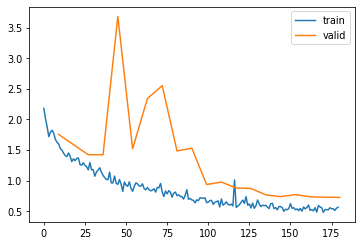

/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)
/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)
/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started 

In [105]:
learn.fit(epochs)

In [106]:
torch.save(learn.model, 'models/best-artwork-20.pkl')

## Data processing (content images)

In [8]:
content_path = path_data/'voc'

In [11]:
content_data_prepped = True

if not content_data_prepped:
    files = list(glob(str(content_path/'*.jpg')))
    train_files, test_files = train_test_split(files, test_size=0.2)

    # Create `train` and `test` folders
    train_folder = content_path/'train'
    test_folder = content_path/'test'
    os.makedirs(train_folder, exist_ok=True)
    os.makedirs(test_folder, exist_ok=True)

    # Move files to `train` folder
    for train_file in train_files:
        shutil.move(train_file, train_folder / os.path.basename(train_file))

    # Move files to `test` folder
    for test_file in test_files:
        shutil.move(test_file, test_folder / os.path.basename(test_file))


In [12]:
class ContentDS:
    def __init__(self, path, train_or_test):
        self.path = Path(path)
        self.files = glob(str(self.path/f"{train_or_test}/*.jpg"), recursive=True)

    def __len__(self): return len(self.files)

    def __getitem__(self, i):
        return self.files[i]

In [13]:
train_content_ds = ContentDS(content_path, "train")
len(train_content_ds)

4008

In [14]:
train_content_ds[0]

'data/voc/train/003301.jpg'

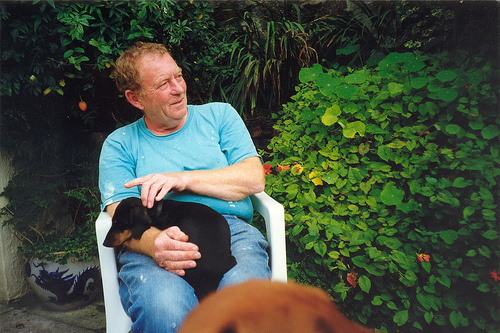

In [15]:
img = Image.open(train_content_ds[0])
display(img)

In [16]:
val_content_ds = ContentDS(content_path, "test")
len(val_content_ds)

1003

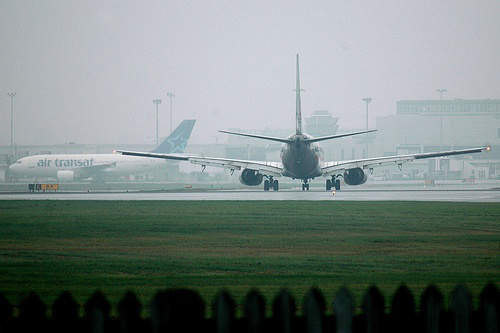

In [17]:
img = Image.open(val_content_ds[0])
display(img)

In [24]:
def content_tfmx(x, erase=True):
    img = Image.open(x)
    transform = transforms.Compose([
        transforms.Resize((64,64)),
        transforms.ToTensor(),
        # transforms.Normalize(x_mean[:,None,None], x_std[:,None,None]),
    ])
    img_t = transform(img)[None]
    if erase: img_t = rand_erase(img_t)
    return img_t[0]


In [19]:
class TfmContentDS:
    def __init__(self, ds, tfmx=fc.noop, tfmy=fc.noop):
        self.ds, self.tfmx, self.tfmy = ds, tfmx, tfmy
    
    def __len__(self):
        return len(self.ds)
    
    def __getitem__(self, i):
        item = self.ds[i]
        return self.tfmx(item), self.tfmy(item)

In [21]:
bs=128

In [22]:
tfm_ctds = TfmContentDS(train_content_ds, content_tfmx, partial(content_tfmx, erase=False))
tfm_cvds = TfmContentDS(val_content_ds, content_tfmx, partial(content_tfmx, erase=False))

dls = DataLoaders(*get_dls(tfm_ctds, tfm_cvds, bs=bs, num_workers=1))

In [23]:
xb, yb = next(iter(dls.train))

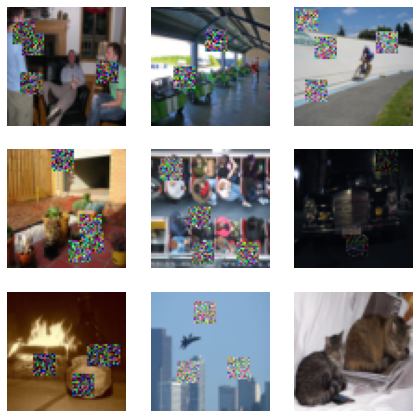

In [24]:
show_images(xb[:9], imsize=2.5)

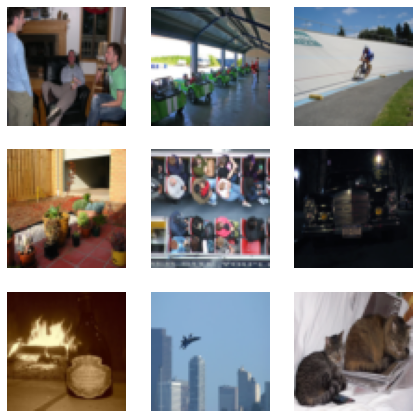

In [25]:
show_images(yb[:9], imsize=2.5)

## U-net
We are using a U-net to reproduce the content image it is given.

In [6]:
def up_block(ni, nf, ks=3, act=act_gr, norm=None):
    return nn.Sequential(nn.UpsamplingNearest2d(scale_factor=2),
                         ResBlock(ni, nf, ks=ks, act=act, norm=norm))

In [7]:
class TinyUnet(nn.Module):
    def __init__(self, act=act_gr, nfs=(32,64,128,256), norm=nn.BatchNorm2d):
        super().__init__()
        self.start = ResBlock(3, nfs[0], stride=1, act=act, norm=norm)
        self.dn = nn.ModuleList([ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2)
                                 for i in range(len(nfs)-1)])
        self.up = nn.ModuleList([up_block(nfs[i], nfs[i-1], act=act, norm=norm)
                                 for i in range(len(nfs)-1,0,-1)])
        self.up += [ResBlock(nfs[0], 3, act=act, norm=norm)]
        self.end = ResBlock(3, 3, act=nn.Identity, norm=norm)

    def forward(self, x):
        layers = []
        layers.append(x)
        x = self.start(x)
        for l in self.dn:
            layers.append(x)
            x = l(x)
        n = len(layers)
        for i,l in enumerate(self.up):
            if i!=0: x += layers[n-i]
            x = l(x)
        return self.end(x+layers[0])

In [8]:
def zero_wgts(l):
    with torch.no_grad():
        l.weight.zero_()
        l.bias.zero_()

In [9]:
model = TinyUnet()

In [10]:
model.up[-1]

ResBlock(
  (convs): Sequential(
    (0): Sequential(
      (0): Conv2d(32, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GeneralRelu()
    )
    (1): Sequential(
      (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (idconv): Sequential(
    (0): Conv2d(32, 3, kernel_size=(1, 1), stride=(1, 1))
  )
  (act): GeneralRelu()
)

In [11]:
last_res = model.up[-1]
zero_wgts(last_res.convs[-1][-1])
zero_wgts(last_res.idconv[0])
zero_wgts(model.end.convs[-1][-1])

First, let's start training a U-net (without the style transfer) to check if it can generate similar images as its inputs.

In [34]:
epochs = 20
lr = 1e-3
tmax = epochs * len(dls.train)
metrics = MetricsCB()
cbs = [DeviceCB(), metrics, ProgressCB(plot=True)]
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
opt_func = partial(optim.AdamW, eps=1e-5)
learn = TrainLearner(model, dls, F.mse_loss, lr=lr, cbs=cbs,opt_func=opt_func)

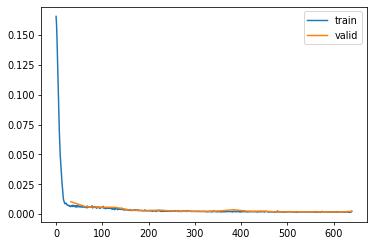

In [35]:
learn.fit(epochs)

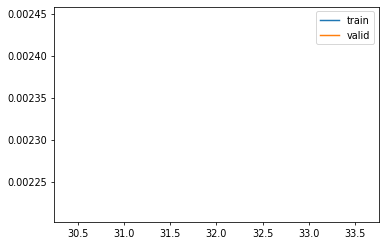

In [36]:
p,t,inp = learn.capture_preds(inps=True)

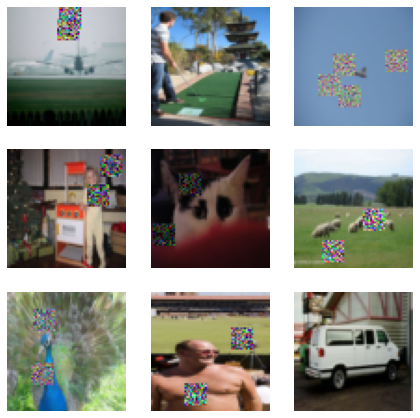

In [37]:
show_images(inp[:9], imsize=2.5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


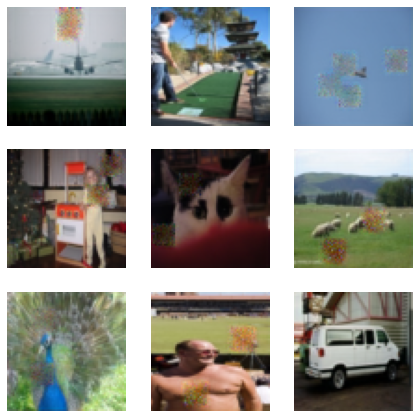

In [38]:
show_images(p[:9], imsize=2.5)

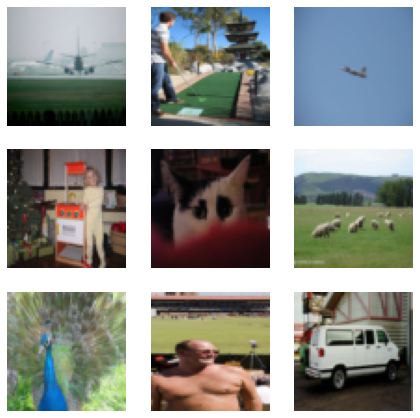

In [41]:
show_images(t[:9], imsize=2.5)

The model still struggles a bit with random erasing, but otherwise it's doing a pretty good job.

## Style loss

In [12]:
cmodel = torch.load('models/best-artwork-20.pkl').to(def_device)

In [13]:
xb, yb = next(iter(dls.valid))
with torch.no_grad():
    preds = to_cpu(cmodel(yb.to(def_device)))
preds.shape

NameError: name 'dls' is not defined

In [45]:
yb.shape

torch.Size([256, 3, 64, 64])

In [46]:
cmodel

Sequential(
  (0): ResBlock(
    (convs): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): GeneralRelu()
      )
      (1): Sequential(
        (0): Conv2d(8, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (idconv): Sequential(
      (0): Conv2d(3, 8, kernel_size=(1, 1), stride=(1, 1))
    )
    (act): GeneralRelu()
  )
  (1): Sequential(
    (0): ResBlock(
      (convs): Sequential(
        (0): Sequential(
          (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): GeneralRelu()
        )
        (1): Sequential(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1),

In [53]:
cmodel[-1]

BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

We want to delete the layers that do not contain information about the features of the images and only keep the ResBlocks.

In [14]:
for i in range(7):
    del(cmodel[-1])

In [15]:
cmodel

Sequential(
  (0): ResBlock(
    (convs): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): GeneralRelu()
      )
      (1): Sequential(
        (0): Conv2d(8, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (idconv): Sequential(
      (0): Conv2d(3, 8, kernel_size=(1, 1), stride=(1, 1))
    )
    (act): GeneralRelu()
  )
  (1): Sequential(
    (0): ResBlock(
      (convs): Sequential(
        (0): Sequential(
          (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): GeneralRelu()
        )
        (1): Sequential(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1),

In [56]:
with torch.no_grad():
    preds = to_cpu(cmodel(yb.to(def_device)))

preds.shape

torch.Size([256, 128, 4, 4])

In [16]:
def gram_matrix(input):
    batch_size, num_feature_maps, h_feature_map, w_feature_map = input.shape
    features = input.view(batch_size * num_feature_maps, h_feature_map * w_feature_map)
    G = torch.mm(features, features.t())
    return G.div(batch_size * num_feature_maps * h_feature_map * w_feature_map)

In [64]:
gram_matrix(preds).shape

torch.Size([32768, 32768])

I have to update my `dls` to contain 2 sets of images (content and style).

## Style and content images

### Data processing

In [17]:
style_path = path_data/'tiny-best-artwork'
content_path = path_data/'voc'

In [18]:
class StyleAndContentDS:
    def __init__(self, style_path, content_path, train_or_test):
        self.style_path = Path(style_path)
        self.content_path = Path(content_path)
        self.style_files = glob(str(self.style_path/f"*/{train_or_test}/*.jpg"), recursive=True)
        self.content_files = glob(str(self.content_path/f"{train_or_test}/*.jpg"), recursive=True)

    def __len__(self): return len(self.style_files)

    def __getitem__(self, i):
        return self.style_files[i], self.content_files[i]

In [19]:
snc_tds = StyleAndContentDS(style_path, content_path, "train")
snc_vds = StyleAndContentDS(style_path, content_path, "test")

In [20]:
snc_tds[0], snc_vds[0]

(('data/tiny-best-artwork/Albrecht_Du╠êrer/train/Albrecht_Du╠êrer_14.jpg',
  'data/voc/train/003301.jpg'),
 ('data/tiny-best-artwork/Albrecht_Du╠êrer/test/Albrecht_Du╠êrer_247.jpg',
  'data/voc/test/005016.jpg'))

In [21]:
class TfmStyleAndContentDS:
    def __init__(self, ds, tfmx=fc.noop, tfmy=fc.noop):
        self.ds, self.tfmx, self.tfmy = ds, tfmx, tfmy
    
    def __len__(self):
        return len(self.ds)
    
    def __getitem__(self, i):
        style_item, content_item = self.ds[i]
        return self.tfmx(content_item), self.tfmy(style_item), self.tfmy(content_item)

In [22]:
def def_tfmx(x):
    img = Image.open(x)
    transform = transforms.Compose([
        transforms.Resize((64,64)),
        transforms.ToTensor(),
        # transforms.Normalize(x_mean[:,None,None], x_std[:,None,None]),
    ])
    img_t = transform(img)
    return img_t

In [59]:
tfm_snc_tds = TfmStyleAndContentDS(snc_tds, tfmx=def_tfmx, tfmy=def_tfmx)
tfm_snc_vds = TfmStyleAndContentDS(snc_vds, tfmx=def_tfmx, tfmy=def_tfmx)

In [60]:
bs=128

In [61]:
dls = DataLoaders(*get_dls(tfm_snc_tds, tfm_snc_vds, bs=bs, num_workers=1))

In [62]:
xc, xs, yc = next(iter(dls.train))

/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


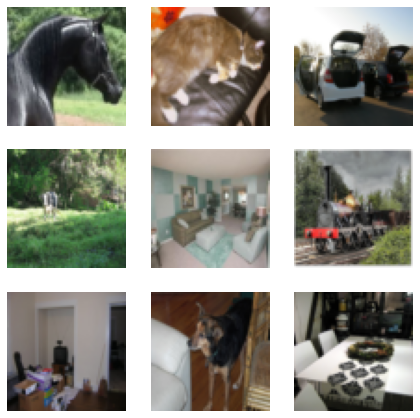

In [63]:
show_images(xc[:9], imsize=2.5)

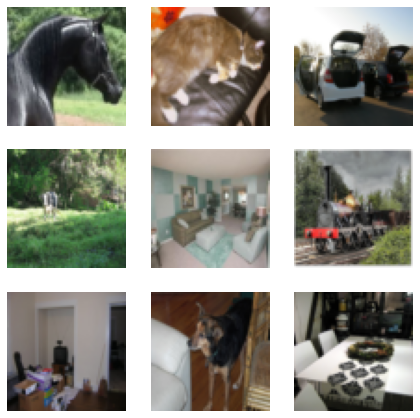

In [64]:
show_images(yc[:9], imsize=2.5)

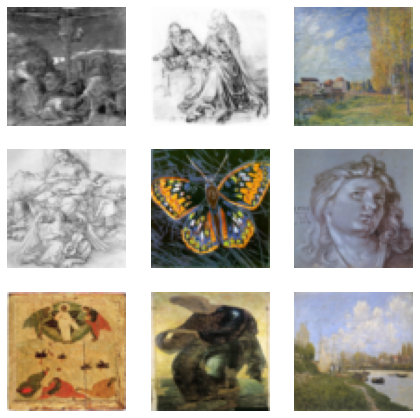

In [65]:
show_images(xs[:9], imsize=2.5)

### Training

We will continue to use our `cmodel` from above to calculate our Gram matrix. [PyTorch's tutorial on NST](https://pytorch.org/tutorials/advanced/neural_style_tutorial.html) involves each of the convolution layers of the pretrained model in computing the style loss. We shall use that as well since only using the final layer gives very small values.

In [66]:
def get_unet():
    model = TinyUnet()
    last_res = model.up[-1]
    zero_wgts(last_res.convs[-1][-1])
    zero_wgts(last_res.idconv[0])
    zero_wgts(model.end.convs[-1][-1])
    return model

In [67]:
def comb_loss(content_pred, style, content_tgt):
    style_scale_factor = 1e1
    style_loss = 0.
    # calculate gram matrices and MSE loss
    with torch.no_grad():
        for i in range(1,5):
            content_pred_feat = cmodel[:i](content_pred)
            style_feat = cmodel[:i](style)

            content_gram = gram_matrix(content_pred_feat)
            style_gram = gram_matrix(style_feat)
        
            style_loss += F.mse_loss(content_gram, style_gram) * style_scale_factor

    content_loss = F.mse_loss(content_pred, content_tgt)
    print(f"Content loss: {content_loss:.4f}, Style loss: {style_loss:.8f}")
    return content_loss + style_loss

In [79]:
epochs = 25
lr = 1e-4
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
opt_func = partial(optim.AdamW, eps=1e-5)
metrics = MetricsCB()
cbs = [DeviceCB(), metrics, ProgressCB(plot=True)]
xtra = [BatchSchedCB(sched)]

In [80]:
class StyleTransferLearner(TrainLearner):
    def get_loss(self):
        self.loss = self.loss_func(self.preds, self.batch[1], self.batch[2])

In [81]:
learn = StyleTransferLearner(get_unet(), dls, comb_loss, lr=lr, cbs=cbs+xtra, opt_func=opt_func)

/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


Content loss: 0.1600, Style loss: 0.00004532
Content loss: 0.1600, Style loss: 0.00004093
Content loss: 0.1599, Style loss: 0.00003609
Content loss: 0.1599, Style loss: 0.00005352
Content loss: 0.1599, Style loss: 0.00003867
Content loss: 0.1598, Style loss: 0.00003806
Content loss: 0.1598, Style loss: 0.00004302
Content loss: 0.1598, Style loss: 0.00003657
Content loss: 0.1597, Style loss: 0.00012877


/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


Content loss: 0.1594, Style loss: 0.00000988
Content loss: 0.1594, Style loss: 0.00123905


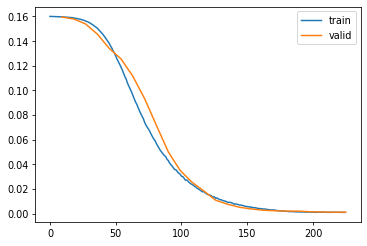

/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


Content loss: 0.1596, Style loss: 0.00003670
Content loss: 0.1596, Style loss: 0.00004125
Content loss: 0.1595, Style loss: 0.00003668
Content loss: 0.1594, Style loss: 0.00003616
Content loss: 0.1593, Style loss: 0.00004603
Content loss: 0.1592, Style loss: 0.00003418
Content loss: 0.1591, Style loss: 0.00005612
Content loss: 0.1590, Style loss: 0.00004516
Content loss: 0.1589, Style loss: 0.00011768


/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


Content loss: 0.1578, Style loss: 0.00000967
Content loss: 0.1578, Style loss: 0.00121258


/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


Content loss: 0.1587, Style loss: 0.00004148
Content loss: 0.1586, Style loss: 0.00004470
Content loss: 0.1584, Style loss: 0.00004002
Content loss: 0.1581, Style loss: 0.00005010
Content loss: 0.1579, Style loss: 0.00004316
Content loss: 0.1577, Style loss: 0.00003688
Content loss: 0.1574, Style loss: 0.00003844
Content loss: 0.1571, Style loss: 0.00003173
Content loss: 0.1567, Style loss: 0.00010580


/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


Content loss: 0.1539, Style loss: 0.00000915
Content loss: 0.1539, Style loss: 0.00114502


/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


Content loss: 0.1563, Style loss: 0.00004188
Content loss: 0.1559, Style loss: 0.00003804
Content loss: 0.1555, Style loss: 0.00003211
Content loss: 0.1549, Style loss: 0.00004039
Content loss: 0.1542, Style loss: 0.00004236
Content loss: 0.1536, Style loss: 0.00004036
Content loss: 0.1528, Style loss: 0.00003735
Content loss: 0.1521, Style loss: 0.00003291
Content loss: 0.1512, Style loss: 0.00010312


/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


Content loss: 0.1456, Style loss: 0.00000804
Content loss: 0.1456, Style loss: 0.00100204


/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


Content loss: 0.1504, Style loss: 0.00003973
Content loss: 0.1493, Style loss: 0.00003512
Content loss: 0.1481, Style loss: 0.00003663
Content loss: 0.1469, Style loss: 0.00003152
Content loss: 0.1458, Style loss: 0.00003024
Content loss: 0.1444, Style loss: 0.00003555
Content loss: 0.1429, Style loss: 0.00003199
Content loss: 0.1413, Style loss: 0.00002665
Content loss: 0.1396, Style loss: 0.00007372


/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


Content loss: 0.1341, Style loss: 0.00000633
Content loss: 0.1342, Style loss: 0.00078324


/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


Content loss: 0.1382, Style loss: 0.00002673
Content loss: 0.1361, Style loss: 0.00002535
Content loss: 0.1344, Style loss: 0.00002524
Content loss: 0.1321, Style loss: 0.00002678
Content loss: 0.1302, Style loss: 0.00002599
Content loss: 0.1278, Style loss: 0.00002696
Content loss: 0.1254, Style loss: 0.00002033
Content loss: 0.1233, Style loss: 0.00001927
Content loss: 0.1211, Style loss: 0.00005570


/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


Content loss: 0.1255, Style loss: 0.00000458
Content loss: 0.1262, Style loss: 0.00056448


/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


Content loss: 0.1188, Style loss: 0.00001956
Content loss: 0.1165, Style loss: 0.00001830
Content loss: 0.1138, Style loss: 0.00001745
Content loss: 0.1111, Style loss: 0.00002062
Content loss: 0.1089, Style loss: 0.00001107
Content loss: 0.1058, Style loss: 0.00001398
Content loss: 0.1034, Style loss: 0.00001388
Content loss: 0.1012, Style loss: 0.00001181
Content loss: 0.0988, Style loss: 0.00002668


/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


Content loss: 0.1114, Style loss: 0.00000300
Content loss: 0.1129, Style loss: 0.00036212


/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


Content loss: 0.0961, Style loss: 0.00000778
Content loss: 0.0933, Style loss: 0.00001151
Content loss: 0.0908, Style loss: 0.00000722
Content loss: 0.0888, Style loss: 0.00001206
Content loss: 0.0860, Style loss: 0.00000844
Content loss: 0.0835, Style loss: 0.00001041
Content loss: 0.0813, Style loss: 0.00000642
Content loss: 0.0789, Style loss: 0.00000730
Content loss: 0.0770, Style loss: 0.00001308


/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


Content loss: 0.0931, Style loss: 0.00000178
Content loss: 0.0950, Style loss: 0.00020298


/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


Content loss: 0.0740, Style loss: 0.00000493
Content loss: 0.0718, Style loss: 0.00000544
Content loss: 0.0702, Style loss: 0.00000603
Content loss: 0.0685, Style loss: 0.00000530
Content loss: 0.0666, Style loss: 0.00000499
Content loss: 0.0643, Style loss: 0.00000491
Content loss: 0.0623, Style loss: 0.00000424
Content loss: 0.0605, Style loss: 0.00000410
Content loss: 0.0591, Style loss: 0.00000956


/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


Content loss: 0.0714, Style loss: 0.00000102
Content loss: 0.0729, Style loss: 0.00010671


/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


Content loss: 0.0567, Style loss: 0.00000305
Content loss: 0.0549, Style loss: 0.00000387
Content loss: 0.0531, Style loss: 0.00000239
Content loss: 0.0512, Style loss: 0.00000318
Content loss: 0.0498, Style loss: 0.00000269
Content loss: 0.0484, Style loss: 0.00000357
Content loss: 0.0472, Style loss: 0.00000351
Content loss: 0.0463, Style loss: 0.00000283
Content loss: 0.0441, Style loss: 0.00000639


/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


Content loss: 0.0501, Style loss: 0.00000061
Content loss: 0.0502, Style loss: 0.00005705


/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


Content loss: 0.0431, Style loss: 0.00000219
Content loss: 0.0410, Style loss: 0.00000260
Content loss: 0.0397, Style loss: 0.00000182
Content loss: 0.0385, Style loss: 0.00000250
Content loss: 0.0370, Style loss: 0.00000277
Content loss: 0.0357, Style loss: 0.00000192
Content loss: 0.0354, Style loss: 0.00000197
Content loss: 0.0338, Style loss: 0.00000229
Content loss: 0.0329, Style loss: 0.00000418


/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


Content loss: 0.0353, Style loss: 0.00000044
Content loss: 0.0335, Style loss: 0.00003679


/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


Content loss: 0.0321, Style loss: 0.00000175
Content loss: 0.0304, Style loss: 0.00000182
Content loss: 0.0301, Style loss: 0.00000234
Content loss: 0.0287, Style loss: 0.00000176
Content loss: 0.0272, Style loss: 0.00000151
Content loss: 0.0274, Style loss: 0.00000209
Content loss: 0.0263, Style loss: 0.00000147
Content loss: 0.0252, Style loss: 0.00000221
Content loss: 0.0244, Style loss: 0.00000315


/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


Content loss: 0.0257, Style loss: 0.00000037
Content loss: 0.0237, Style loss: 0.00002911


/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


Content loss: 0.0238, Style loss: 0.00000165
Content loss: 0.0232, Style loss: 0.00000120
Content loss: 0.0222, Style loss: 0.00000140
Content loss: 0.0216, Style loss: 0.00000148
Content loss: 0.0205, Style loss: 0.00000203
Content loss: 0.0200, Style loss: 0.00000183
Content loss: 0.0193, Style loss: 0.00000125
Content loss: 0.0185, Style loss: 0.00000126
Content loss: 0.0177, Style loss: 0.00000550


/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


Content loss: 0.0185, Style loss: 0.00000033
Content loss: 0.0171, Style loss: 0.00002543


/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


Content loss: 0.0181, Style loss: 0.00000122
Content loss: 0.0169, Style loss: 0.00000194
Content loss: 0.0161, Style loss: 0.00000106
Content loss: 0.0156, Style loss: 0.00000138
Content loss: 0.0153, Style loss: 0.00000128
Content loss: 0.0149, Style loss: 0.00000171
Content loss: 0.0142, Style loss: 0.00000188
Content loss: 0.0135, Style loss: 0.00000128
Content loss: 0.0137, Style loss: 0.00000235


/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


Content loss: 0.0110, Style loss: 0.00000031
Content loss: 0.0108, Style loss: 0.00002301


/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


Content loss: 0.0125, Style loss: 0.00000143
Content loss: 0.0128, Style loss: 0.00000172
Content loss: 0.0122, Style loss: 0.00000171
Content loss: 0.0114, Style loss: 0.00000140
Content loss: 0.0114, Style loss: 0.00000111
Content loss: 0.0109, Style loss: 0.00000097
Content loss: 0.0106, Style loss: 0.00000152
Content loss: 0.0103, Style loss: 0.00000144
Content loss: 0.0099, Style loss: 0.00000182


/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


Content loss: 0.0077, Style loss: 0.00000030
Content loss: 0.0082, Style loss: 0.00002205


/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


Content loss: 0.0093, Style loss: 0.00000109
Content loss: 0.0092, Style loss: 0.00000133
Content loss: 0.0093, Style loss: 0.00000093
Content loss: 0.0088, Style loss: 0.00000140
Content loss: 0.0085, Style loss: 0.00000145
Content loss: 0.0077, Style loss: 0.00000156
Content loss: 0.0080, Style loss: 0.00000142
Content loss: 0.0076, Style loss: 0.00000127
Content loss: 0.0075, Style loss: 0.00000444


/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


Content loss: 0.0052, Style loss: 0.00000030
Content loss: 0.0063, Style loss: 0.00002158


/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


Content loss: 0.0070, Style loss: 0.00000153
Content loss: 0.0070, Style loss: 0.00000116
Content loss: 0.0069, Style loss: 0.00000113
Content loss: 0.0065, Style loss: 0.00000111
Content loss: 0.0062, Style loss: 0.00000146
Content loss: 0.0059, Style loss: 0.00000161
Content loss: 0.0058, Style loss: 0.00000095
Content loss: 0.0055, Style loss: 0.00000143
Content loss: 0.0056, Style loss: 0.00000266


/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


Content loss: 0.0038, Style loss: 0.00000030
Content loss: 0.0049, Style loss: 0.00002176


/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


Content loss: 0.0051, Style loss: 0.00000094
Content loss: 0.0052, Style loss: 0.00000103
Content loss: 0.0049, Style loss: 0.00000113
Content loss: 0.0049, Style loss: 0.00000180
Content loss: 0.0047, Style loss: 0.00000136
Content loss: 0.0042, Style loss: 0.00000199
Content loss: 0.0043, Style loss: 0.00000133
Content loss: 0.0040, Style loss: 0.00000099
Content loss: 0.0042, Style loss: 0.00000197


/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


Content loss: 0.0028, Style loss: 0.00000030
Content loss: 0.0034, Style loss: 0.00002187


/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


Content loss: 0.0038, Style loss: 0.00000155
Content loss: 0.0039, Style loss: 0.00000111
Content loss: 0.0037, Style loss: 0.00000136
Content loss: 0.0034, Style loss: 0.00000159
Content loss: 0.0034, Style loss: 0.00000090
Content loss: 0.0032, Style loss: 0.00000140
Content loss: 0.0031, Style loss: 0.00000124
Content loss: 0.0031, Style loss: 0.00000094
Content loss: 0.0030, Style loss: 0.00000233


/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


Content loss: 0.0024, Style loss: 0.00000029
Content loss: 0.0027, Style loss: 0.00002131


/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


Content loss: 0.0030, Style loss: 0.00000137
Content loss: 0.0027, Style loss: 0.00000087
Content loss: 0.0025, Style loss: 0.00000107
Content loss: 0.0025, Style loss: 0.00000178
Content loss: 0.0023, Style loss: 0.00000179
Content loss: 0.0022, Style loss: 0.00000123
Content loss: 0.0024, Style loss: 0.00000111
Content loss: 0.0019, Style loss: 0.00000103
Content loss: 0.0021, Style loss: 0.00000232


/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


Content loss: 0.0021, Style loss: 0.00000029
Content loss: 0.0023, Style loss: 0.00002105


/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


Content loss: 0.0020, Style loss: 0.00000095
Content loss: 0.0019, Style loss: 0.00000087
Content loss: 0.0017, Style loss: 0.00000140
Content loss: 0.0018, Style loss: 0.00000186
Content loss: 0.0017, Style loss: 0.00000162
Content loss: 0.0017, Style loss: 0.00000074
Content loss: 0.0016, Style loss: 0.00000103
Content loss: 0.0016, Style loss: 0.00000164
Content loss: 0.0015, Style loss: 0.00000278


/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


Content loss: 0.0021, Style loss: 0.00000028
Content loss: 0.0023, Style loss: 0.00001974


/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


Content loss: 0.0016, Style loss: 0.00000126
Content loss: 0.0014, Style loss: 0.00000143
Content loss: 0.0014, Style loss: 0.00000084
Content loss: 0.0015, Style loss: 0.00000111
Content loss: 0.0014, Style loss: 0.00000096
Content loss: 0.0013, Style loss: 0.00000142
Content loss: 0.0013, Style loss: 0.00000116
Content loss: 0.0013, Style loss: 0.00000120
Content loss: 0.0013, Style loss: 0.00000473


/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


Content loss: 0.0016, Style loss: 0.00000027
Content loss: 0.0017, Style loss: 0.00001943


/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


Content loss: 0.0014, Style loss: 0.00000103
Content loss: 0.0013, Style loss: 0.00000208
Content loss: 0.0013, Style loss: 0.00000132
Content loss: 0.0012, Style loss: 0.00000114
Content loss: 0.0011, Style loss: 0.00000080
Content loss: 0.0012, Style loss: 0.00000108
Content loss: 0.0012, Style loss: 0.00000097
Content loss: 0.0013, Style loss: 0.00000111
Content loss: 0.0012, Style loss: 0.00000346


/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


Content loss: 0.0013, Style loss: 0.00000027
Content loss: 0.0015, Style loss: 0.00001925


/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


Content loss: 0.0013, Style loss: 0.00000122
Content loss: 0.0013, Style loss: 0.00000156
Content loss: 0.0012, Style loss: 0.00000236
Content loss: 0.0011, Style loss: 0.00000096
Content loss: 0.0011, Style loss: 0.00000089
Content loss: 0.0011, Style loss: 0.00000075
Content loss: 0.0012, Style loss: 0.00000088
Content loss: 0.0012, Style loss: 0.00000126
Content loss: 0.0012, Style loss: 0.00000306


/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


Content loss: 0.0013, Style loss: 0.00000027
Content loss: 0.0014, Style loss: 0.00001915


/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


Content loss: 0.0011, Style loss: 0.00000148
Content loss: 0.0012, Style loss: 0.00000120
Content loss: 0.0012, Style loss: 0.00000115
Content loss: 0.0012, Style loss: 0.00000169
Content loss: 0.0011, Style loss: 0.00000093
Content loss: 0.0012, Style loss: 0.00000087
Content loss: 0.0011, Style loss: 0.00000136
Content loss: 0.0011, Style loss: 0.00000097
Content loss: 0.0011, Style loss: 0.00000266


/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


Content loss: 0.0012, Style loss: 0.00000027
Content loss: 0.0014, Style loss: 0.00001910


In [82]:
learn.fit(epochs)

/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


Content loss: 0.0012, Style loss: 0.00000027
Content loss: 0.0014, Style loss: 0.00001910


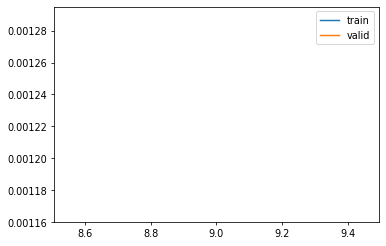

In [83]:
p, t, inp = learn.capture_preds(inps=True)

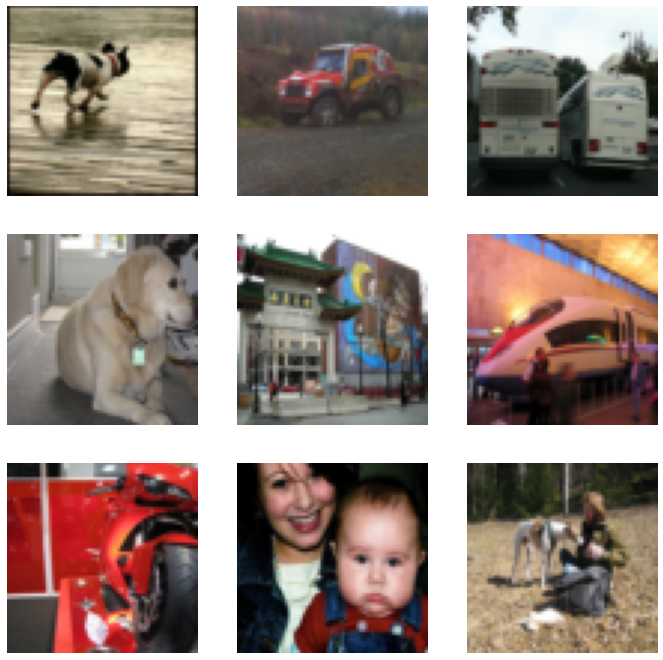

In [87]:
show_images(inp[30:39], imsize=4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


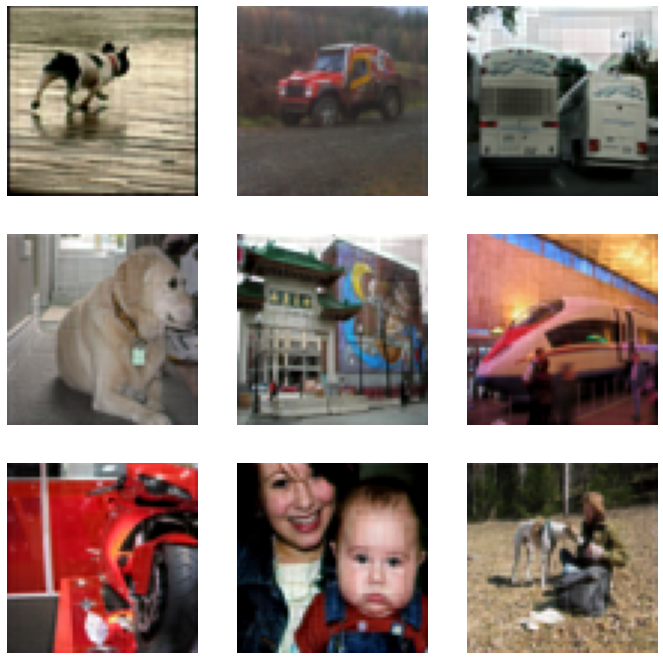

In [88]:
show_images(p[30:39], imsize=4)

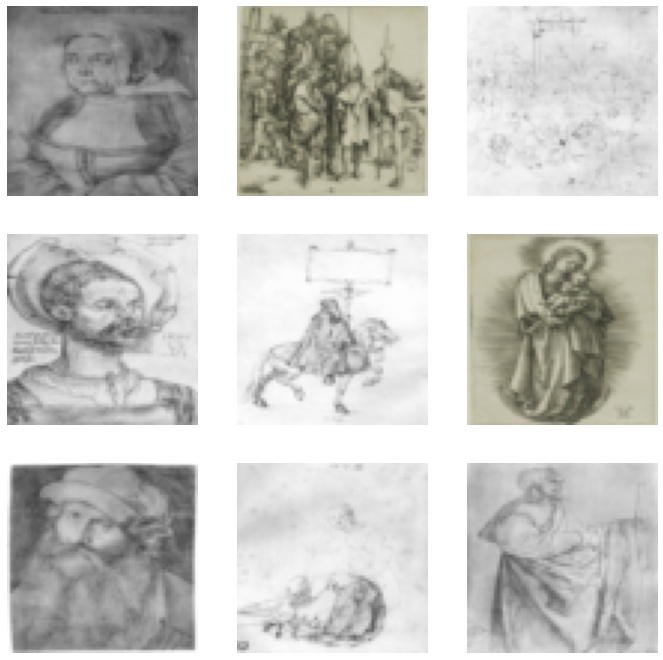

In [89]:
show_images(t[30:39], imsize=4)

In [156]:
xc, xs, yc = next(iter(dls.valid))

/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


In [157]:
xc.shape, xs.shape, yc.shape

(torch.Size([256, 3, 64, 64]),
 torch.Size([256, 3, 64, 64]),
 torch.Size([256, 3, 64, 64]))

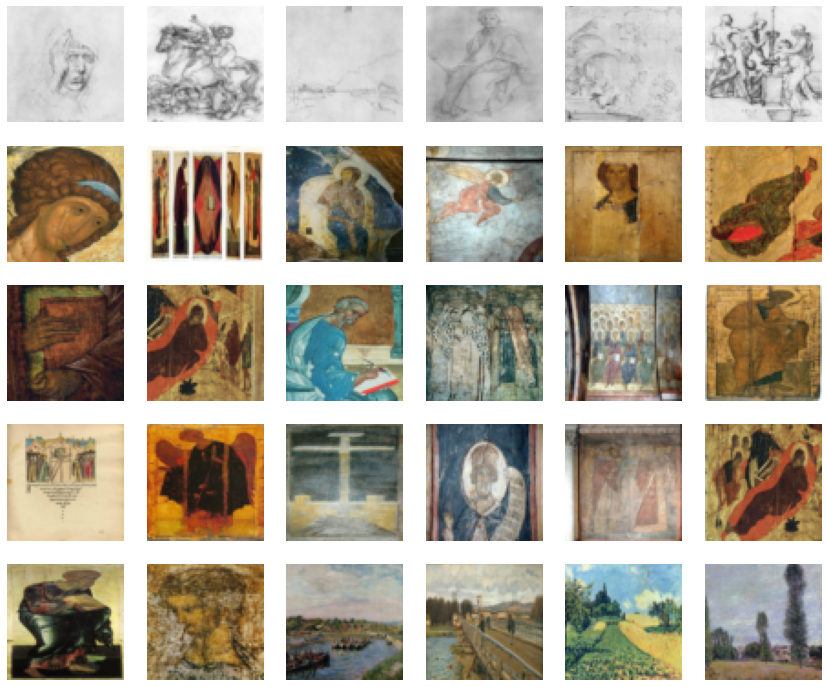

In [161]:
show_images(xs[60:90], imsize=2.5)